In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from tabulate import tabulate
%matplotlib inline

# 1. Adaboost
## 1.1 Construct dataframe from data

In [2]:
# For testing all cities
cities = ['amsterdam', 'athens', 'barcelona', 'berlin', 'budapest', 'lisbon', 
          'london', 'paris', 'rome', 'vienna']

# For testing individual cities
# cities = ['amsterdam']

days = ['weekdays', 'weekends']

k = 0

datasets = []
for city in cities:
    city_data = pd.DataFrame()
    for day in days:
        file_name = './data/' + city + '_' + day + '.csv'
        data = pd.read_csv(file_name)
        data = data.drop(data.columns[0], axis=1)
        data['city'] = city
        if (day == 'weekdays'):
            data['weekdays'] = 1;
        else:
            data['weekdays'] = 0;
        city_data = pd.concat([city_data, data])
    datasets.append(city_data)
datasets[4].head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,weekdays
0,238.990459,Entire home/apt,False,False,6.0,True,0,1,10.0,99.0,...,0.359355,0.352643,404.404677,24.116552,893.477343,67.656853,19.05074,47.50076,budapest,1
1,300.794285,Entire home/apt,False,False,6.0,False,0,1,9.0,98.0,...,0.929427,0.200235,1676.876030,100.000000,452.539717,34.267700,19.04493,47.50405,budapest,1
2,162.381915,Entire home/apt,False,False,4.0,True,0,0,10.0,98.0,...,2.450840,0.279452,163.588493,9.755551,191.992270,14.538245,19.02170,47.49882,budapest,1
3,118.437750,Entire home/apt,False,False,2.0,False,0,0,9.0,92.0,...,1.559449,0.477971,191.719844,11.433155,326.215588,24.702048,19.06301,47.51126,budapest,1
4,134.417446,Entire home/apt,False,False,4.0,True,1,0,10.0,99.0,...,1.113803,0.270102,198.603460,11.843658,635.515884,48.123218,19.06900,47.49900,budapest,1


In [3]:
datasets[4]['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

## 1.2 Preprocessing data.
### 1.2.1 encoding all categorical features. Tree model does not require standardization. 

In [4]:
datasets_preprocessed = []
    
for i in range(len(datasets)):
    city = datasets[i][datasets[i].room_type != 'Shared room']


    # Specify features to encode
    features = list(city.columns);
    onehot_encoding_feature = ["room_type"];
    binary_ordinal_encoding_feature = ["room_shared", "room_private", "host_is_superhost"];
    target_encoding_feature = ["city"];

    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelBinarizer

    # Remove unnecessary features and separate features from target
    X = city.drop(["lng", "lat", "attr_index_norm", "rest_index_norm", "realSum"], axis = 1);
   
    y = city["realSum"];

    # Split into dev and test sets
    X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create copies for preprocessing
    X_dev_preprocessed = copy.deepcopy(X_dev)
    X_test_preprocessed = copy.deepcopy(X_test)
 
    # One-hot encode appropriate features
    X_dev_preprocessed = pd.get_dummies(X_dev_preprocessed, columns=onehot_encoding_feature)
    X_test_preprocessed = pd.get_dummies(X_test_preprocessed, columns=onehot_encoding_feature)
    
    # Binary encode appropriate features
    for features in binary_ordinal_encoding_feature:
        ordinal_encoder = LabelBinarizer()
        X_dev_preprocessed[features] = ordinal_encoder.fit_transform(X_dev_preprocessed[features].to_numpy().reshape(-1, 1))
        X_test_preprocessed[features] = ordinal_encoder.transform(X_test_preprocessed[features].to_numpy().reshape(-1, 1))

    # Target encode appropriate features with mean of target of units in the feature group
    from category_encoders.target_encoder import TargetEncoder
    for features in target_encoding_feature:
        X_dev_preprocessed[features + "_te"] = y_dev.mean()
        X_test_preprocessed[features + "_te"] = y_dev.mean()    
    
    datasets_preprocessed.append((copy.deepcopy(X_dev_preprocessed), copy.deepcopy(y_dev), copy.deepcopy(X_test_preprocessed), copy.deepcopy(y_test)))

In [5]:
X_dev_entire = pd.DataFrame();
y_dev_entire = pd.DataFrame();
X_test_entire = pd.DataFrame();
y_test_entire = pd.DataFrame();


In [6]:
for i in range(len(datasets_preprocessed)):
    X_dev_entire = pd.concat([X_dev_entire, datasets_preprocessed[i][0]]);
    y_dev_entire = pd.concat([y_dev_entire, datasets_preprocessed[i][1]]);
    X_test_entire = pd.concat([X_test_entire, datasets_preprocessed[i][2]]);
    y_test_entire = pd.concat([y_test_entire, datasets_preprocessed[i][3]]);


In [7]:
assert(X_dev_entire.shape[0] == y_dev_entire.shape[0])
assert(X_test_entire.shape[0] == y_test_entire.shape[0])

In [8]:
X_dev_entire.head()

,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,rest_index,city,weekdays,room_type_Entire home/apt,room_type_Private room,city_te
852,0,1,4.0,0,0,0,9.0,90.0,2,0.435388,0.304292,574.800306,826.222187,amsterdam,1,0,1,578.661557
1048,0,0,2.0,0,1,0,9.0,94.0,1,3.736897,0.895566,154.583775,189.252508,amsterdam,1,1,0,578.661557
176,0,0,3.0,0,0,0,9.0,90.0,1,3.312730,0.516880,131.024148,165.082683,amsterdam,1,1,0,578.661557
132,0,1,2.0,0,0,0,8.0,91.0,1,0.226415,0.442660,568.625736,784.750431,amsterdam,0,0,1,578.661557
541,0,0,4.0,0,0,1,10.0,91.0,3,3.388188,2.111546,120.950292,150.356352,amsterdam,1,1,0,578.661557


### 1.2.2 Drop sparse columns

room_shared
1.0


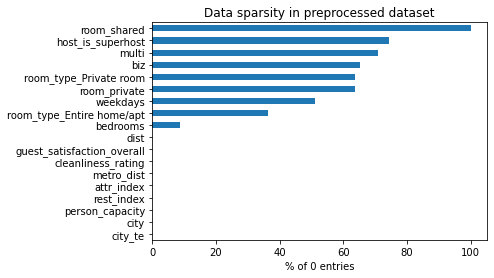

In [9]:
sparsity = pd.Series((X_dev_entire.shape[0] - np.count_nonzero(X_dev_entire, axis = 0)) * 100 / X_dev_entire.shape[0],
                    index = X_dev_entire.columns).sort_values(ascending = True)
ax = sparsity.plot.barh(title = "Data sparsity in preprocessed dataset");
ax.set_xlabel("% of 0 entries")

sparsity_threshold = 0.8;
for features in X_dev_entire.columns:
    sparsity = (X_dev_entire.shape[0] - 
                np.count_nonzero(X_dev_entire[features], axis = 0)) / X_dev_entire.shape[0]
    
    if (sparsity > sparsity_threshold):
        print(features)
        print(sparsity)
        X_dev_entire = X_dev_entire.drop([features], axis = 1)
        X_test_entire = X_test_entire.drop([features], axis = 1)
                


### 1.2.2 Drop correlated columns

[('room_private', 'room_type_Entire home/apt'), ('room_private', 'room_type_Private room'), ('attr_index', 'rest_index'), ('room_type_Entire home/apt', 'room_type_Private room')]


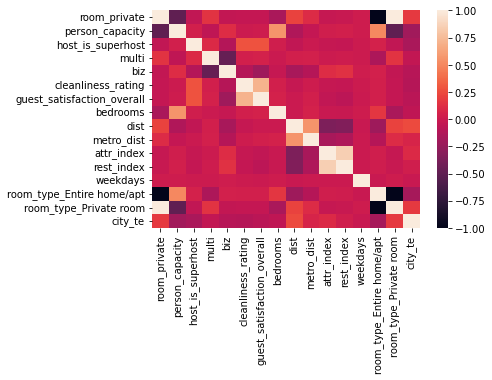

In [10]:
corrM = X_dev_entire.select_dtypes(include=np.number).corr()
sns.heatmap(corrM)
num_features = X_dev_entire.select_dtypes(include=np.number).columns;
high_corr_pair = []
for feature1 in num_features:
    for feature2 in num_features:
        if (np.abs(corrM[feature1][feature2]) >= 0.8
            and (feature2, feature1) not in high_corr_pair
            and feature1 != feature2):
            high_corr_pair.append((feature1, feature2))
print(high_corr_pair)

In [11]:
X_dev_entire = X_dev_entire.drop(['room_private', 'room_type_Entire home/apt', 'rest_index'], axis=1)
X_test_entire = X_test_entire.drop(['room_private', 'room_type_Entire home/apt', 'rest_index'], axis=1)

In [12]:
X_dev_entire.head()

,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,city,weekdays,room_type_Private room,city_te
852,4.0,0,0,0,9.0,90.0,2,0.435388,0.304292,574.800306,amsterdam,1,1,578.661557
1048,2.0,0,1,0,9.0,94.0,1,3.736897,0.895566,154.583775,amsterdam,1,0,578.661557
176,3.0,0,0,0,9.0,90.0,1,3.312730,0.516880,131.024148,amsterdam,1,0,578.661557
132,2.0,0,0,0,8.0,91.0,1,0.226415,0.442660,568.625736,amsterdam,0,1,578.661557
541,4.0,0,0,1,10.0,91.0,3,3.388188,2.111546,120.950292,amsterdam,1,0,578.661557


### 1.3 Build Adaboost model

In [13]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV
parameters_Adaboost = {'n_estimators':[5,10,15, 20], 
                       'learning_rate':[0.2, 0.25, 0.3, 0.35, 0.4], 
                       'loss':['linear','square', 'exponential']}

clf_Adaboost = GridSearchCV(estimator = AdaBoostRegressor(random_state = 42), 
                               param_grid = parameters_Adaboost, 
                               cv = 5,
                               refit=True
                              )
%time clf_Adaboost.fit(X_dev_entire.drop(['city'], axis = 1), np.array(np.log(y_dev_entire)).flatten())

CPU times: user 2min 28s, sys: 498 ms, total: 2min 29s
Wall time: 2min 29s


GridSearchCV(cv=5, estimator=AdaBoostRegressor(random_state=42),
             param_grid={'learning_rate': [0.2, 0.25, 0.3, 0.35, 0.4],
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': [5, 10, 15, 20]})

In [14]:
best_Adaboost_tree = clf_Adaboost.best_estimator_;
print(clf_Adaboost.best_params_)

{'learning_rate': 0.25, 'loss': 'exponential', 'n_estimators': 20}


### 1.3 Evaluate Adaboost model

In [15]:
data_X_city_test = X_test_entire.drop(['city'], axis = 1);

data_y_city_test = np.array(np.log(y_test_entire)).flatten();
y_pred = best_Adaboost_tree.predict(data_X_city_test);
print(f'Adaboost Regressor for entire dataset has the following scores:')
print(f'R^2:', best_Adaboost_tree.score(data_X_city_test, data_y_city_test));
print(f'MSE', mean_squared_error(data_y_city_test, y_pred));
print(f'MAE', mean_absolute_error(data_y_city_test, y_pred));
print(f'MAPE', mean_absolute_percentage_error(data_y_city_test, y_pred));

Adaboost Regressor for entire dataset has the following scores:
R^2: 0.5586229498499331
MSE 0.1626080829338228
MAE 0.30819018797352676
MAPE 0.057202781465150045


### 1.3 Interpret Adaboost model

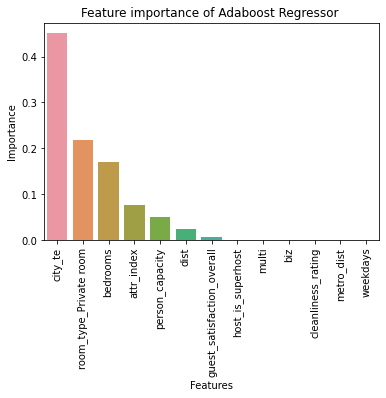

In [16]:
feature_importance_adaboost = best_Adaboost_tree.feature_importances_
features_adaboost = X_dev_entire.drop(['city'], axis = 1).columns

df = pd.DataFrame(list(zip(features_adaboost, np.abs(feature_importance_adaboost ))),
                      columns=['Features', "Importance"])

bar_plot = sns.barplot(data=df, x="Features", y="Importance", 
                order=df.sort_values('Importance',ascending = False).Features
               ).set_title("Feature importance of Adaboost Regressor ")
plt.xticks(rotation=90)
plt.show()

# 2. Causal Inference on the effect of operating a hotel in high attraction area
## 2.1. Constructing causal graph.
### 2.1.1. We see that in elastic net regression for each city, attraction index is moderately important in dictating the price, therefore an inference on the effect of attraction index on price would be interesting. We know standardization make data smaller than median negative and larget than median positive, thus we mark hotel with positove normalized attr_index high attraction and hotel with negative normalized attr_index low attraction. We can see there are two possible confouding variables that influence both attraction index and price: weekday and dist. 
### 2.1.2 Weekend is possibly a confounder because we might get more tourist during weekend and thus make hotel location more attractive and also high demand drives the price up. Dist is also a possible confounder because closer to the city center more attractive the hotel is and also property in city center are inherently more expensive due to demand. We will investigate average treatment effect of selecting a high or low attraction index location for hotel on the price.
### 2.1.3 The team will investigate how selecting high attraction index location impact price for each city.

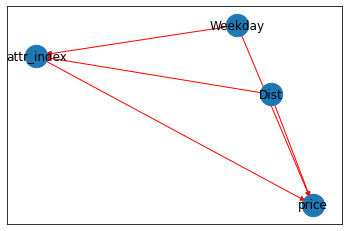

In [17]:
import networkx as nx
G = nx.DiGraph()
G.add_node("Weekday")
G.add_node("Dist")
G.add_node("attr_index")
G.add_node("price")

G.add_edge("Weekday","attr_index")
G.add_edge("Weekday","price")
G.add_edge("attr_index","price")
G.add_edge("Dist","attr_index")
G.add_edge("Dist","price")

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size = 500)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='r', arrows = True)

plt.show()

## 2.2 Data Processing
### 2.2.1 The procedure will make use of all data, thus development and test dataset will be concatenated.
### 2.2.2 Select relevent data

In [18]:
df_X_whole = pd.concat([X_dev_entire, X_test_entire], ignore_index=True, sort=False)
df_y_whole = pd.concat([y_dev_entire, y_test_entire], ignore_index=True, sort=False)
df_X_causal = df_X_whole[["dist", 'attr_index', 'weekdays', 'city']];
df_y_causal = df_y_whole;

In [19]:
def _High_Low_attr(row):    
   
    if row["attr_index"] > 0:
        return 1
    else:
        return 0;
        
    return 0;

## 3.2 Build model

In [21]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.api import WLS
cities = ['amsterdam', 'athens', 'barcelona', 'berlin', 'budapest', 'lisbon', 
          'london', 'paris', 'rome', 'vienna']

for individual_cities in cities:
    indexCity = df_X_causal[df_X_causal['city'] == individual_cities].index;
    data_X_city = df_X_causal.iloc[indexCity];

    data_X_city = data_X_city.drop(['city'], axis = 1)
    data_y_city = df_y_causal.iloc[indexCity];
    
    dist_scaler = StandardScaler()
    data_X_city['dist'] = dist_scaler.fit_transform(np.array(data_X_city['dist']).reshape(-1,1))
    
    attr_scaler = StandardScaler()
    data_X_city['attr_index'] = attr_scaler.fit_transform(np.array(data_X_city['attr_index']).reshape(-1,1))
    
    data_X_city['attr_bi'] =  data_X_city.apply(_High_Low_attr, axis=1)
    data_X_city = data_X_city.drop(['attr_index'], axis = 1)
    
    # Propensity score model:
    data_X_city['price'] = data_y_city;
    data_X_city['intercept'] = 1;
    propensity_model = Logit(endog=data_X_city['attr_bi'], 
              exog=data_X_city[['weekdays', 'dist', 'intercept']]);
    propensity_model_result = propensity_model.fit(disp=0);
    
    data_X_city['propensity_score'] = data_X_city['attr_bi'] * propensity_model_result.predict() + \
                         (1 - data_X_city['attr_bi']) * (1 - propensity_model_result.predict())
    data_X_city['weight'] = 1. / data_X_city['propensity_score']
    # Fit weighted least square model with propensity weight, which makes WLS loss unbiased 
    WLS_model = WLS(endog= data_y_city, 
            exog=data_X_city[['attr_bi', 'weekdays', 'dist', 'intercept']],
            weights=data_X_city['weight']
           )
    WLS_model_result = WLS_model.fit(disp=0);

    #Compute average treatment effect to see expected difference of price for the hotels in the city
    #given intervention on attraction index 
    df_0 = data_X_city.copy()
    df_0['attr_bi'] = 0
    data_X_city['price_pred_0'] = WLS_model_result.predict(exog=df_0[['attr_bi', 'weekdays', 'dist','intercept']])
    E_p_0 = data_X_city['price_pred_0'].mean() #E(price|do(attr_bi = 0))
    
    df_1 = data_X_city.copy()
    df_1['attr_bi'] = 1
    data_X_city['price_pred_1'] = WLS_model_result.predict(exog=df_1[['attr_bi', 'weekdays', 'dist','intercept']])
    E_p_1 = data_X_city['price_pred_1'].mean(); #E(price|do(attr_bi = 1))
    
    ATE = E_p_1 - E_p_0;
    
    assert(np.abs(ATE - WLS_model_result.params['attr_bi']) < 0.01)
    Naive_ATE = data_X_city[data_X_city['attr_bi'] == 1]['price'].mean() - data_X_city[data_X_city['attr_bi'] == 0]['price'].mean()
    print(f'Naive Average treatment effect of hotel price between high and low attr_index in the city {individual_cities} is {np.round(Naive_ATE,3)}')
    print(f'Average treatment effect of hotel price between high and low attr_index in the city {individual_cities} is {np.round(ATE,3)}')
    print(" ")

Naive Average treatment effect of hotel price between high and low attr_index in the city amsterdam is 192.007
Average treatment effect of hotel price between high and low attr_index in the city amsterdam is 22.299
 
Naive Average treatment effect of hotel price between high and low attr_index in the city athens is 59.93
Average treatment effect of hotel price between high and low attr_index in the city athens is 18.665
 
Naive Average treatment effect of hotel price between high and low attr_index in the city barcelona is 59.593
Average treatment effect of hotel price between high and low attr_index in the city barcelona is 32.225
 
Naive Average treatment effect of hotel price between high and low attr_index in the city berlin is 101.231
Average treatment effect of hotel price between high and low attr_index in the city berlin is 76.394
 
Naive Average treatment effect of hotel price between high and low attr_index in the city budapest is 27.989
Average treatment effect of hotel pric